<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>💎Diamonds</font>](https://www.kaggle.com/competitions/22jan24jh-diamonds)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json file is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 22jan24jh-diamonds         # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 22jan24jh-diamonds
Using competition: 22jan24jh-diamonds
  teamId  teamName            submissionDate       score            
--------  ------------------  -------------------  ---------------  
11561236  3 Diamonds💎         2024-02-03 18:34:46  567.6963105000   
11580589  8 Diamonds          2024-02-04 03:07:13  600.9779260000   
11575741  DiamondDiggers      2024-02-05 00:45:26  603.0398164999   
11585011  9 Diamonds          2024-02-02 23:25:38  609.1472885000   
11586129  Diamond_5           2024-02-04 04:48:13  618.5244364999   
11570995  4 Diamonds          2024-02-03 19:46:24  635.0945530000   
11580504  💎6                  2024-02-04 20:47:05  637.9146890000   
11584680  2 Diamonds          2024-02-05 00:18:54  640.2757900000   
11596471  Team-24-Diamonds    2024-02-04 19:56:13  823.1705574999   
11503718  💎Baseline 🐍         2024-01-12 16:31:46  1066.5654285000  
11567537  Aaron Collinsworth 

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 218 ms, sys: 63 µs, total: 218 ms
Wall time: 221 ms


In [ ]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
df.price.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200000 entries, 0 to 199999
Series name: price
Non-Null Count   Dtype  
--------------   -----  
160000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

# ScatterCorrHist(tXY.head(200))  # takes a minute time to run

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    200000 non-null  float64
 1   depth    200000 non-null  float64
 2   table    200000 non-null  float64
 3   x        200000 non-null  float64
 4   y        200000 non-null  float64
 5   z        200000 non-null  float64
 6   cut      200000 non-null  object 
 7   color    200000 non-null  object 
 8   clarity  200000 non-null  object 
 9   price    160000 non-null  float64
dtypes: float64(7), object(3)
memory usage: 15.3+ MB


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error


# PREPROCESSING

<Axes: xlabel='carat', ylabel='price'>

<ipython-input-180-efae4edc4f67>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object['cut'] = ordinal_encoder.fit_transform(df_object[['cut']])


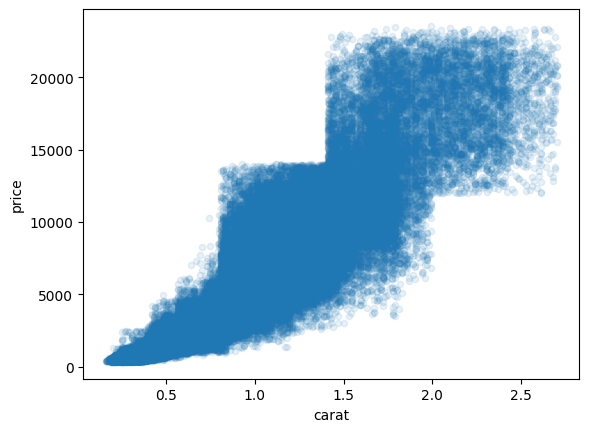

In [ ]:
# Preprocessing & Cleaning of training data tXY
df_clean=tXY.copy()

# Getting rid of outliers
df_clean = df_clean[~((df_clean['carat'] >= 2.0) & (df_clean['carat'] <= 3.0) & (df_clean['price'] >= 5000) & (df_clean['price'] <= 12000))]
df_clean = df_clean[df_clean['carat'] <= 2.7]
df_clean = df_clean[~((df_clean['carat'] >= 1.0) & (df_clean['carat'] <= 1.3) & (df_clean['price'] >= 15000) & (df_clean['price'] <= 20000))]
df_clean = df_clean[~((df_clean['carat'] >= 0.7) & (df_clean['carat'] <= 1.4) & (df_clean['price'] >= 14000) & (df_clean['price'] <= 25000))]
df_clean.plot(kind="scatter", x="carat", y="price", alpha=0.1)

# Adding FEATURES
# adding a new feature called diameter. d = cube root of (carat * 6.4)
df_clean['diameter'] = (df_clean['carat'] ** (1/3)) * 6.4

# adding another feature called volume. volume = diameter * depth * table
df_clean['volume'] = df_clean['diameter'] * df_clean['depth'] * df_clean['table']

# splitting clean dataset into numerical and object
df_num = df_clean[['price', 'x', 'y','z', 'diameter','volume','carat','depth','table']]
df_object = df_clean[['cut', 'color', 'clarity']]

# encoding color and clarity by OHE and cut by ordinal

# Define the order for ordinal encoding of 'cut'
cut_order = ['F', 'G', 'V', 'P', 'I']

# Initialize the encoders
ordinal_encoder = OrdinalEncoder(categories=[cut_order])
onehot_encoder = OneHotEncoder(drop='first', sparse=False)

# Ordinal encode 'cut'
df_object['cut'] = ordinal_encoder.fit_transform(df_object[['cut']])

# One-hot encode 'color' and 'clarity'
df_encoded = pd.get_dummies(df_object, columns=['color', 'clarity'])

# combining the number and object dataframe
df_processed = pd.concat([df_num, df_encoded], axis=1)


# PREPPING FOR TRAINING

In [ ]:
# Prepping the data for splitting
dfX = df_processed.loc[:, df_processed.columns != 'price']
dfy = df_processed.loc[:, df_processed.columns == 'price'].values.ravel()

# Split the original dataset into train (75%) and temp (25%)
train_df, temp_df = train_test_split(df_processed, test_size=0.25, random_state=42)

# For training set
X_train = train_df.drop(columns=['price'])  # Features
y_train = train_df['price']  # Target variable

# MODEL

In [ ]:
# Create a ridgeregression model
model = Ridge(alpha=10, solver='auto', tol=0.005)

In [ ]:
# Create a pipeline with standard scaling, polynomial features, and Ridge regression
pipe_all = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), model)

# Fit the model on the training set
pipe_all.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge(alpha=10, tol=0.005))])

# FITTING MODEL ON WHOLE DATASET

In [ ]:
# converting vX as per pre-processing

# Preprocessing & Cleaning of training data tXY
vX_clean=vX.copy()

# Adding FEATURES
# adding a new feature called diameter. d = cube root of (carat * 6.4)
vX_clean['diameter'] = (vX_clean['carat'] ** (1/3)) * 6.4

# adding another feature called volume. volume = diameter * depth * table
vX_clean['volume'] = vX_clean['diameter'] * vX_clean['depth'] * vX_clean['table']


# splitting clean dataset into numerical and object
vX_num = vX_clean[['x', 'y','z', 'diameter','volume','carat','depth','table']]
vX_object = vX_clean[['cut', 'color', 'clarity']]

# Define the order for ordinal encoding of 'cut'
cut_order = ['F', 'G', 'V', 'P', 'I']

# Initialize the encoders
ordinal_encoder = OrdinalEncoder(categories=[cut_order])
onehot_encoder = OneHotEncoder(sparse=False)  # drop='first' to avoid multicollinearity

# Ordinal encode 'cut'
vX_object['cut'] = ordinal_encoder.fit_transform(vX_object[['cut']])

# One-hot encode 'color' and 'clarity'
vX_encoded = pd.get_dummies(vX_object, columns=['color', 'clarity'])

# combining the number and object dataframe
vX_processed = pd.concat([vX_num, vX_encoded], axis=1)

<ipython-input-184-391f1c1a34d1>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vX_object['cut'] = ordinal_encoder.fit_transform(vX_object[['cut']])


In [ ]:
# Applyin the model fitted on whole dataset to predict missing 40k prices
vX_pred = pipe_all.predict(vX_processed)

In [ ]:
pY = pd.DataFrame(vX_pred, index=range(1, len(vX_pred) + 1), columns=['price'])  # ensure that labels and observations are in corresponding order

pY = pY.clip(lower=10)  # ensures no negative prices

ToCSV(pY, '💎Final')

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

We used several feature engineering methods to see whether we could down-select the features into a subset of what was given in the data. We attempted Stepwise Feature Selection, Recursive Feature Selection with cross-validation, as well as forwards and backwards Sequential Feature Selectors. After using all these selectors and methodologies, we found that using all features was the best.

We did find that by using the “carat” feature, we could create a new feature called “diameter” and apply it to the dataset, which improved the performance of the model significantly. The diameter was calculated by multiplying the carat feature value by one-third, then 6.4. Another feature we created was the “volume” feature, which utilizes the newly created “diameter” feature as well as the preexisting “depth” and “table” features. “volume” was calculated by multiplying those three features together. Both of these features served to improve the performance of our model and were thought of by using the paper cited in reference [1].

Using the suggestions from the above reference, we also removed outliers from the dataset to avoid too much skewing of the data toward extremes. Outliers were determined using a combination of the “carat” feature and the “price” value.

For encoding the features that were nominal. We researched whether there was any worth in applying ordinal encoding to the features. When we did this, we found that diamond prices were affected by the values contained within and each rating for color, cut, and clarity had an inherent ordering in value. However, we also found that if we tried ordinal encoding on all features using this order, it did not help to improve scores, but if we applied it to only one of the features, we did see a significant jump in the performance of a model. After testing the different possible combinations of ordinal and one-hot encoding, we determined that applying ordinal encoding to cut and one-hot encoding color and clarity gave the best results.

The two main ways we evaluated were that, first, we used visualization techniques to explore their individual relationships. Then we used cross-validation on default linear regression models with different sets of engineered features and compared the resulting MAE and RMSE values against each other and selecting the feature sets that performed the best with those models.

We tried quite a number of techniques that ended in less-than-ideal results. One of the first things we tried doing was examining the correlation between features. We saw that depth was negatively correlated with price, so we attempted to remove it as a feature and found that did not help improve the final results. We did this with a few other sets of features, and it did not work. We attempted to apply both PCA and kernel PCA to little results as well. Several different normalization techniques were also applied to the data in hopes of bettering our results, although all these did not fair, as well as just applying a standard scaling to the features.






<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>
Explain Decisions in Modeling Pipeline

Our initial approach to modeling was first testing several different model types. Of these types, we tested Linear Regression, Ridge, Lasso, and ElasticNet. For each of these models, we tested a basic version of the model with default parameters and applied cross-validation techniques, and determined which of these models performed the best with the data available. After determining that Ridge performed the best of the models tested, we turned to hyperparameter tuning techniques. For the purposes of this project, we treated the use of creating a polynomial feature set as part of the hyperparameter tuning. We first attempted to use Grid Search with cross-validation in the Google Colab setting but found that it did not have enough computational resources to use this methodology. After encountering this problem, we moved hyperparameter tuning efforts to local machines that did not have limited resources and could be left to run for a while. After the Grid Search was finished running, we tried applying the recommended hyperparameters to our model in Google Colab; however, this led to a longer runtime than the maximum amount of time allotted. Determining that the main issue with this was due to the hyperparameters, we went back and did some more grid search, eliminating the value that we thought was causing the longest hang-up in training our model. We repeated this step several times until we sat around the maximum run time. Determining that any more changes to hyperparameters would be too detrimental to the final model, we decided to reduce the number of data points the model was trained on. We reduced the number to 75% of the dataset and used that as the training dataset. This decision served two purposes it helps avoid overfitting the data while also reducing training time.

For reference, throughout this process of iterative testing different model pipelines, we were constantly applying cross-validation to verify that the models worked well not just on the test and train sets but also on a held-out validation set. The performance of these models was judged using the loss functions MAE and RMSE.

In the end, the final model pipeline we settled on was a 3-degree Polynomial Feature generator into a Ridge model with the hyperparameters of alpha = 10, solver = auto, and tol = 0.005.



<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

</font>

1. Kigo, S.N., Omondi, E.O. & Omolo, B.O. Assessing predictive performance of supervised machine learning algorithms for a diamond pricing model. Sci Rep 13, 17315 (2023). https://doi.org/10.1038/s41598-023-44326-w
2. Pandas.concat#. pandas.concat - pandas 2.2.0 documentation. (n.d.). https://pandas.pydata.org/docs/reference/api/pandas.concat.html
3. Pandas.dataframe.drop#. pandas.DataFrame.drop - pandas 2.2.0 documentation. (n.d.). https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
4. Pandas.get_dummies#. pandas.get_dummies - pandas 2.2.0 documentation. (n.d.-a). https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
5. Pandas.get_dummies#. pandas.get_dummies - pandas 2.2.0 documentation. (n.d.-b). https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
6. Running python functions as pipeline jobs¶. Joblib. (n.d.). https://joblib.readthedocs.io/en/stable/
7. Sklearn.linear_model.Ridge. scikit. (n.d.-a). https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
8. SKLEARN.METRICS.MEAN_ABSOLUTE_ERROR. scikit. (n.d.-b). https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
9. Sklearn.model_selection.cross_val_score. scikit. (n.d.-c). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
10. Sklearn.model_selection.GRIDSEARCHCV. scikit. (n.d.-d). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
11. Sklearn.model_selection.train_test_split. scikit. (n.d.-e). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
12. Sklearn.pipeline.make_pipeline. scikit. (n.d.-f). https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html
13. Sklearn.preprocessing.onehotencoder. scikit. (n.d.-g). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
14. Sklearn.preprocessing.OrdinalEncoder. scikit. (n.d.-h). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
15. Sklearn.preprocessing.PolynomialFeatures. scikit. (n.d.-i). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
16. Sklearn.preprocessing.StandardScaler. scikit. (n.d.-j). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
17. 2023 guide to different types of Diamond Cuts + diamond cut chart. Brilliant Earth. (n.d.). https://www.brilliantearth.com/diamond/buying-guide/cut/
18. Géron, A. (2019). Hands-on machine learning with scikit-learn, Keras, and tensorflow: Concepts, tools, and techniques to build Intelligent Systems. O’Reilly.
19. S, M. (n.d.). Angara.com. https://www.angara.com/blog/diamond-clarity-and-color-chart/?cid=ps-acc%21Google%7CGlobal-DSA%7CUSA-us-ct%21pse-cmp%2112734058433-adg%21159215764249-ad%21683703017440-kwd%21-pl%21-dt%21-mt%21&utm_source=google&source_medium=cpc&gad_source=1&gclid=Cj0KCQiA2eKtBhDcARIsAEGTG40LJjK68B7tCUQij7hkZi6b1FD-cFrg94MXHkio3SZwRCTTYGUNUv0aAkaAEALw_wcB




<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 44 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions ($x_i^a$, $x_ix_j$, ...) to identify new key features or their linear combinations. With too many features you can use a smaller subsample or reduce dimensionality of feature space using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), or [UMAP](https://umap-learn.readthedocs.io/en/latest/).
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features?
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
